In [204]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math
from scipy import stats

In [167]:
all_df = pd.read_pickle("all_df.pkl")

In [168]:
all_df["any_sepsis"] = all_df.groupby('patient id')['SepsisLabel'].transform(lambda x: 1 if x.any() else 0)

## SIRS measure

In [87]:
condition = (np.isnan(all_df['Temp']) & np.isnan(all_df['HR']) & np.isnan(all_df['Resp']) & np.isnan(all_df['WBC']))
all_df['hasSIRS'] = np.where(condition, 1, 0)
all_df['hasSIRS'].value_counts()

hasSIRS
0    695525
1     71359
Name: count, dtype: int64

In [88]:
a = all_df['WBC'] * 10**3
a.describe()

count     49059.000000
mean      11453.655598
std        7487.563950
min         100.000000
25%        7600.000000
50%       10300.000000
75%       13750.000000
max      440000.000000
Name: WBC, dtype: float64

In [89]:
all_df['WBC'].describe()

count    49059.000000
mean        11.453656
std          7.487564
min          0.100000
25%          7.600000
50%         10.300000
75%         13.750000
max        440.000000
Name: WBC, dtype: float64

In [90]:
condition_temp=(all_df['Temp'] > 38) | ( all_df['Temp'] < 36)
condition_HR=(all_df['HR'] > 90)
condition_Resp=(all_df['Resp'] > 20) | ( all_df['PaCO2'] < 32)
condition_wbc=(all_df['WBC']* 10**3 > 12000) |( all_df['WBC']* 10**3 < 4000)

all_df['SIRS_score'] = np.where(condition_temp, 1, 0)+np.where(condition_HR, 1, 0)+np.where(condition_Resp, 1, 0)+np.where(condition_wbc, 1, 0)

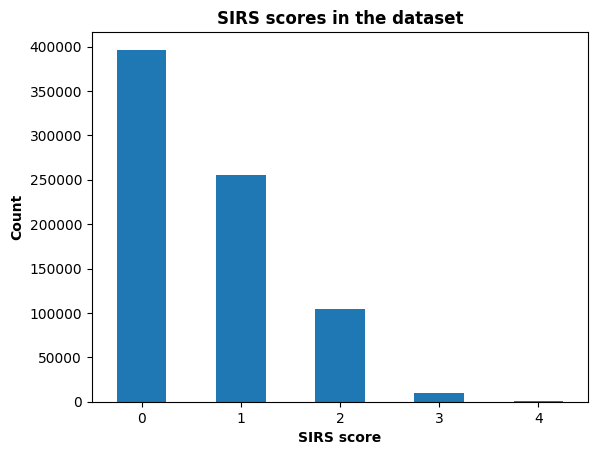

In [18]:
# sns.histplot(data=all_df, x="SIRS_score", binwidth=0.5)
# plt.title("SIRS score in the dataset")
# plt.grid(False)
# plt.show()

all_df['SIRS_score'].value_counts().plot.bar()
plt.ylabel('Count', fontweight = "bold")
plt.xticks(rotation=0, ha='center', fontsize=10)
plt.xlabel('SIRS score', fontweight = "bold")
plt.title("SIRS scores in the dataset", fontweight = "bold")
plt.show()

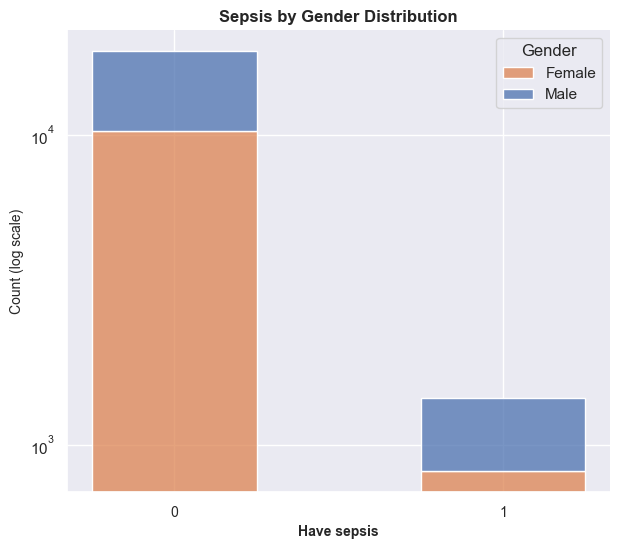

In [225]:
sns.histplot(data=all_df.drop_duplicates(subset=["patient id", "Gender", "any_sepsis"]), x="any_sepsis", hue="Gender", multiple="stack", binwidth=0.5, binrange=(-0.25, 1.25))
plt.xticks([0,1], ha='center', fontsize=10)
plt.yscale('log')
sns.despine()
plt.legend(title="Gender", labels=["Female", "Male"])
plt.xlabel('Have sepsis', fontweight = "bold")
plt.ylabel("Count (log scale)")
plt.title("Sepsis by Gender Distribution", fontweight = "bold")
plt.show()

C:\Users\maaya\AppData\Local\Temp\ipykernel_21980\219283348.py:31: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label="p-value")


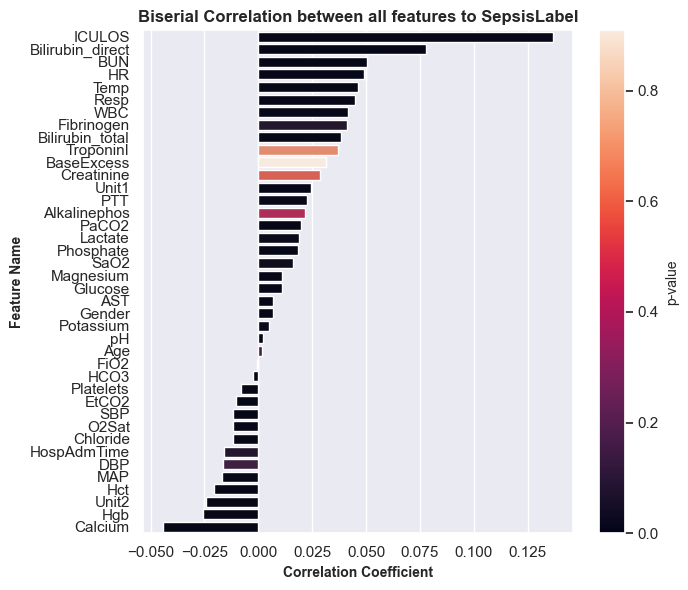

In [180]:
corr_values = {}
p_values = {}
for col in all_df.columns:
    if col not in ["SepsisLabel", "patient id", "any_sepsis"]:
        non_nan = all_df.dropna(subset=[col])
        corr, pval = pointbiserialr(non_nan[col], non_nan["SepsisLabel"])
        corr_values[col] = corr
        p_values[col] = pval

# Sort the dictionaries by absolute correlation values
sorted_values = sorted(zip(corr_values.values(), p_values.values(), corr_values.keys()), key=lambda x: x[0], reverse=True)
corr_series = pd.Series([x[0] for x in sorted_values], index=[x[2] for x in sorted_values])
p_series = pd.Series([x[1] for x in sorted_values], index=[x[2] for x in sorted_values])

# Create color mapping based on p-values
vmax = max(p_values.values())
cmap = sns.cm.rocket
p_colors = [cmap(p/vmax) for p in p_values.values()]

# Create figure and axis objects
fig, ax = plt.subplots()

# Create bar plot of correlation values
sns.barplot(x=corr_series.values, 
            y=corr_series.index,
            palette=p_colors)

# Add legend for color mapping
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=vmax))
sm.set_array([])
plt.colorbar(sm, label="p-value")

# Set plot title and labels
ax.set_title("Biserial Correlation between all features to SepsisLabel", fontweight = "bold")
ax.set_xlabel("Correlation Coefficient", fontweight = "bold")
ax.set_ylabel("Feature Name", fontweight = "bold")

plt.tight_layout()

#sns.set(rc={'font.size':10, 'axes.titlesize':12, 'axes.labelsize':10})

plt.show()

In [171]:
def plot_corr(feature1, feature2, seperator, seperator_vals):
    for val in seperator_vals:
        plt.scatter(x=all_df[all_df[seperator] == val][feature1], y=all_df[all_df[seperator] == val][feature2], label = f"{seperator} {val}")
    plt.legend()
    plt.title(f"{feature1} vs {feature2}")
    plt.show()

In [207]:
corrs_p_values = {}
for i, col1 in enumerate(all_df.columns):
    for j, col2 in enumerate(all_df.columns):
        not_nan_df = all_df.dropna(subset=[col1,col2])
        if i < j:
            corr, p = stats.pearsonr(not_nan_df[col1], not_nan_df[col2])
            if corr >= 0.5 or corr <= -0.5:
                corrs_p_values[(col1, col2)] = (corr, p)

In [212]:
corrs_p_values

{('SBP', 'MAP'): (0.7817974980713378, 0.0),
 ('SBP', 'DBP'): (0.5421353875821167, 0.0),
 ('MAP', 'DBP'): (0.8514820342348233, 0.0),
 ('BaseExcess', 'HCO3'): (0.8495152245268334, 0.0),
 ('BaseExcess', 'pH'): (0.6532852726817399, 0.0),
 ('HCO3', 'PaCO2'): (0.5369497405849637, 0.0),
 ('BUN', 'Creatinine'): (0.631362098483196, 0.0),
 ('BUN', 'Phosphate'): (0.543122576085213, 0.0),
 ('Creatinine', 'Phosphate'): (0.5454326737236533, 0.0),
 ('Bilirubin_direct', 'Bilirubin_total'): (0.9524445030170607, 0.0),
 ('Hct', 'Hgb'): (0.9537081162670719, 0.0),
 ('Unit1', 'Unit2'): (-1.0, 0.0)}

In [172]:
corrs = all_df.corr()
corr_matrix = np.triu(corrs, k=1)
corr_filtered = pd.DataFrame(corr_matrix, columns=all_df.columns, index=all_df.columns)
corr_filtered = corr_filtered[((corr_filtered >= 0.5) & (corr_filtered != 1)) | (corr_filtered <=-0.5)]
dict_filtered = corr_filtered.to_dict()

not_nan_corrs = {}
for k_out,v_out in dict_filtered.items():
    for k_in, v_in in v_out.items():
        if not math.isnan(v_in):
            not_nan_corrs[(k_out, k_in)] = v_in

In [173]:
not_nan_corrs

{('MAP', 'SBP'): 0.7817974980713348,
 ('DBP', 'SBP'): 0.5421353875821201,
 ('DBP', 'MAP'): 0.8514820342348793,
 ('HCO3', 'BaseExcess'): 0.849515224526835,
 ('pH', 'BaseExcess'): 0.653285272681737,
 ('PaCO2', 'HCO3'): 0.5369497405849661,
 ('Creatinine', 'BUN'): 0.6313620984832218,
 ('Phosphate', 'BUN'): 0.5431225760852111,
 ('Phosphate', 'Creatinine'): 0.5454326737236502,
 ('Bilirubin_total', 'Bilirubin_direct'): 0.9524445030170615,
 ('Hgb', 'Hct'): 0.9537081162670704,
 ('Unit2', 'Unit1'): -1.0000000000000004}

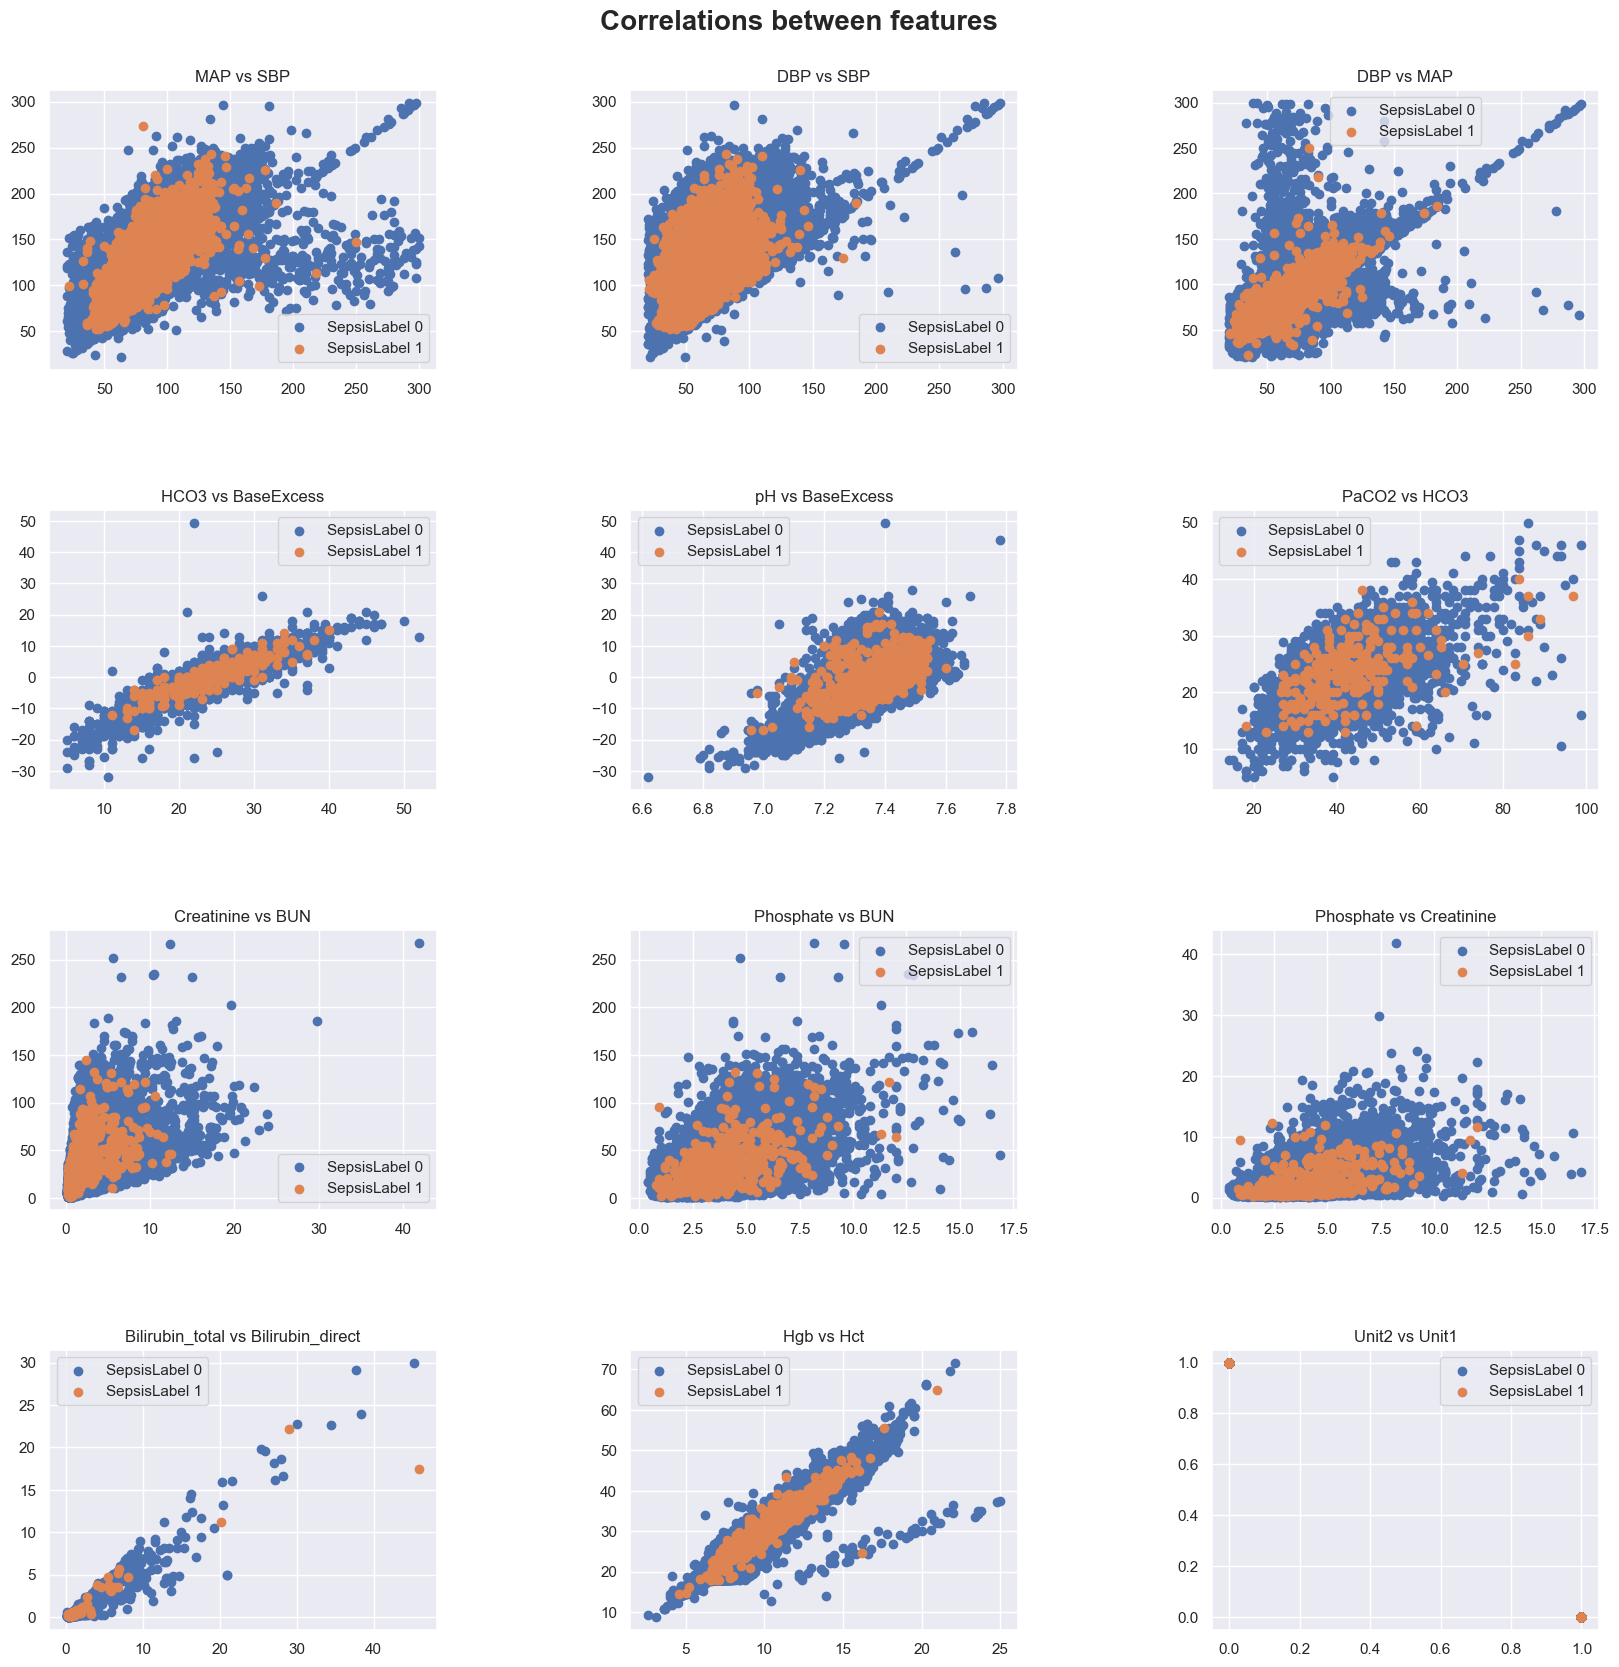

In [182]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20, 20))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
fig.suptitle("Correlations between features", fontsize=20, fontweight="bold", y=0.92)

seperator = "SepsisLabel"
for i, pair in enumerate(not_nan_corrs.keys()):
    feature1, feature2 = pair
    ax = axes[i // 3, i % 3]
    for val in all_df[seperator].unique():
        ax.scatter(x=all_df[all_df[seperator] == val][feature1], y=all_df[all_df[seperator] == val][feature2], label=f"{seperator} {val}")
    ax.legend()
    ax.set_title(f"{feature1} vs {feature2}")

plt.show()

c:\users\maaya\appdata\local\programs\python\python39\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


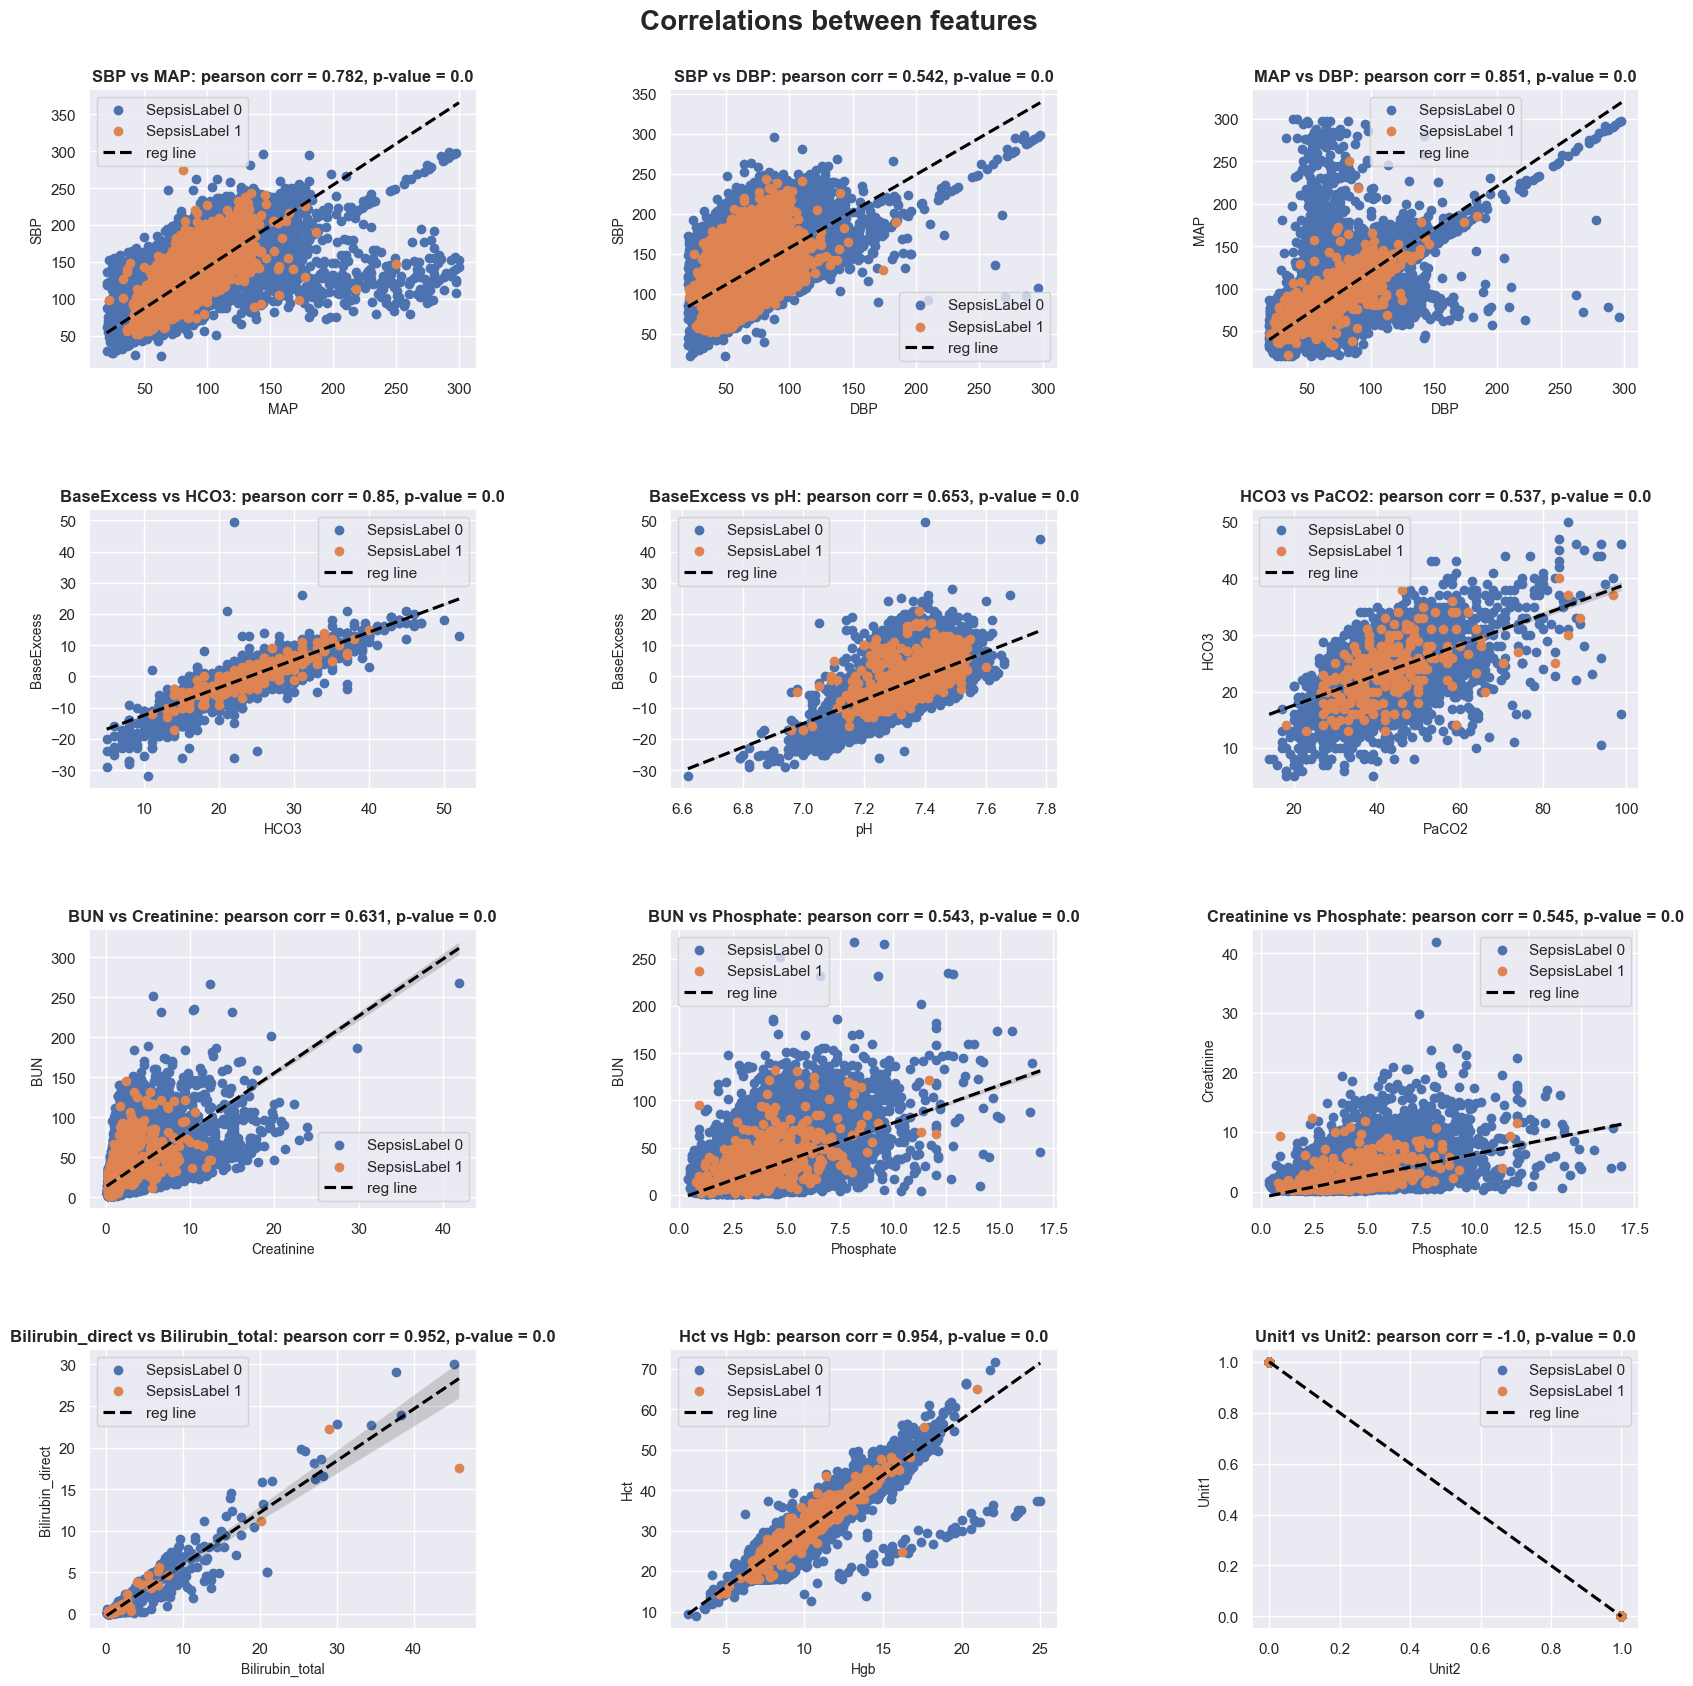

In [213]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20, 20))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
fig.suptitle("Correlations between features", fontsize=20, fontweight="bold", y=0.92)

seperator = "SepsisLabel"
for i, pair in enumerate(not_nan_corrs.keys()):
    feature1, feature2 = pair
    ax = axes[i // 3, i % 3]
    for val in all_df[seperator].unique():
        ax.scatter(x=all_df[all_df[seperator] == val][feature1], y=all_df[all_df[seperator] == val][feature2], label=f"{seperator} {val}")
    sns.regplot(x=feature1, y=feature2, data=all_df, ax=ax, scatter=False, color='black', label="reg line", line_kws={'linestyle':'--'})
    ax.legend()
    ax.set_title(f"{feature2} vs {feature1}: pearson corr = {round(not_nan_corrs[(feature1, feature2)], 3)}, p-value = 0.0", fontweight="bold")

plt.show()

In [199]:
not_nan_corrs

{('MAP', 'SBP'): 0.7817974980713348,
 ('DBP', 'SBP'): 0.5421353875821201,
 ('DBP', 'MAP'): 0.8514820342348793,
 ('HCO3', 'BaseExcess'): 0.849515224526835,
 ('pH', 'BaseExcess'): 0.653285272681737,
 ('PaCO2', 'HCO3'): 0.5369497405849661,
 ('Creatinine', 'BUN'): 0.6313620984832218,
 ('Phosphate', 'BUN'): 0.5431225760852111,
 ('Phosphate', 'Creatinine'): 0.5454326737236502,
 ('Bilirubin_total', 'Bilirubin_direct'): 0.9524445030170615,
 ('Hgb', 'Hct'): 0.9537081162670704,
 ('Unit2', 'Unit1'): -1.0000000000000004}

In [216]:
a = all_df["Unit1"] + all_df["Unit2"]
a.unique()

array([ 1., nan])

In [6]:
df_train_impute = all_df.copy()
columns_impute = list(df_train_impute.columns)
grouped_by_patient = df_train_impute.groupby('patient id')
df_train_impute = grouped_by_patient.apply(lambda x: x.bfill().ffill())

In [7]:
df_train_impute

HR  O2Sat   Temp    SBP   MAP   DBP  Resp  EtCO2   
patient id                                                              
0          0       61.0   99.0  36.44  124.0  65.0  43.0  17.5    NaN  \
           1       61.0   99.0  36.44  124.0  65.0  43.0  17.5    NaN   
           2       64.0   98.0  36.22  125.0  64.0  41.0  27.0    NaN   
           3       56.0  100.0  36.22  123.0  65.0  41.0   9.0    NaN   
           4       66.0   99.0  36.22  120.0  67.0  43.0  23.0    NaN   
...                 ...    ...    ...    ...   ...   ...   ...    ...   
19999      766879  76.0   99.0  36.33   85.0  53.0   NaN  17.0    NaN   
           766880  81.0   99.0  36.33   99.0  51.0   NaN  17.0    NaN   
           766881  85.0  100.0  36.33  103.0  48.0   NaN  26.0    NaN   
           766882  86.0   93.0  36.33   87.0  44.0   NaN  22.0    NaN   
           766883  84.0   85.0  36.33   78.0  44.0   NaN  18.0    NaN   

                   BaseExcess  HCO3  ...  Fibrinogen  Platelets    Age   
patient id                           ...                                 
0          0              NaN  22.0  ...         NaN      158.0  75.91  \
           1              NaN  22.0  ...         NaN      158.0  75.91   
           2              NaN  22.0  ...         NaN      158.0  75.91   
           3              NaN  22.0  ...         NaN      158.0  75.91   
           4              NaN  22.0  ...         NaN      158.0  75.91   
...                       ...   ...  ...         ...        ...    ...   
19999      766879        19.0  48.0  ...         NaN      338.0  83.14   
           766880        19.0  48.0  ...         NaN      338.0  83.14   
           766881        19.0  48.0  ...         NaN      338.0  83.14   
           766882        19.0  48.0  ...         NaN      338.0  83.14   
           766883        19.0  48.0  ...         NaN      338.0  83.14   

                   Gender  Unit1  Unit2  HospAdmTime  ICULOS  SepsisLabel   
patient id                                                                  
0          0            0    0.0    1.0       -98.60       1            0  \
           1            0    0.0    1.0       -98.60       2            0   
           2            0    0.0    1.0       -98.60       3            0   
           3            0    0.0    1.0       -98.60       4            0   
           4            0    0.0    1.0       -98.60       5            0   
...                   ...    ...    ...          ...     ...          ...   
19999      766879       0    NaN    NaN        -0.03      50            0   
           766880       0    NaN    NaN        -0.03      51            0   
           766881       0    NaN    NaN        -0.03      52            0   
           766882       0    NaN    NaN        -0.03      53            0   
           766883       0    NaN    NaN        -0.03      54            0   

                   patient id  
patient id                     
0          0                0  
           1                0  
           2                0  
           3                0  
           4                0  
...                       ...  
19999      766879       19999  
           766880       19999  
           766881       19999  
           766882       19999  
           766883       19999  

[766884 rows x 42 columns]

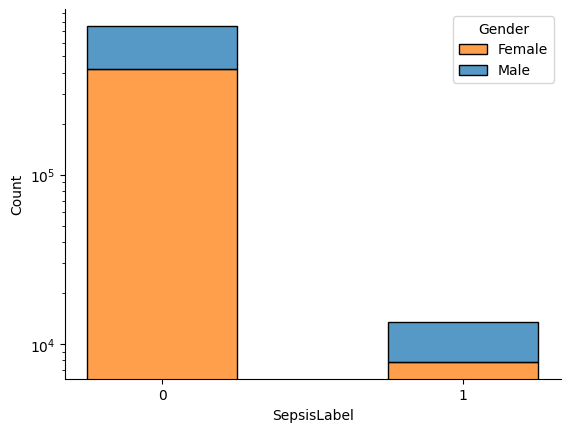

In [37]:
sns.histplot(data=all_df, x="SepsisLabel", hue="Gender", multiple="stack", binwidth=0.5, binrange=(-0.25, 1.25))
plt.xticks([0,1], ha='center', fontsize=10)
plt.yscale('log')
sns.despine()
plt.legend(title="Gender", labels=["Female", "Male"])
plt.show()

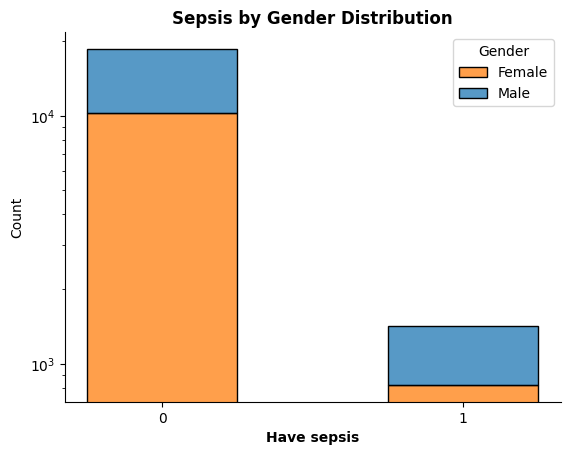

In [43]:
sns.histplot(data=all_df.drop_duplicates(subset=["patient id", "Gender", "any_sepsis"]), x="any_sepsis", hue="Gender", multiple="stack", binwidth=0.5, binrange=(-0.25, 1.25))
plt.xticks([0,1], ha='center', fontsize=10)
plt.yscale('log')
sns.despine()
plt.legend(title="Gender", labels=["Female", "Male"])
plt.xlabel('Have sepsis', fontweight = "bold")
plt.ylabel("Count")
plt.title("Sepsis by Gender Distribution", fontweight = "bold")
plt.show()